In [1]:
import yfinance as yf
import pandas as pd

# 设置下载数据的时间范围为2021年一整年
start_date = '2021-01-01'
end_date = '2021-12-31'

# 设置测试数据的时间范围为2021年之后的一个月
# 注意：如果2021年12月的数据不完整，则测试数据的开始日期应为最后一个完整的交易日
test_start_date = '2022-01-01'
test_end_date = '2022-01-31'

# 定义沪深300指数的ticker
ticker = "000300.SS"

# 使用yfinance下载数据
data = yf.download(ticker, start=start_date, end=end_date)
test_data = yf.download(ticker, start=test_start_date, end=test_end_date)

# 检查数据
print(data.tail())  # 打印训练数据集的最后几行
print(test_data.head())  # 打印测试数据集的前几行

# 如果需要，可以将数据保存到CSV文件
# data.to_csv('training_data_2021.csv')
# test_data.to_csv('test_data_2022.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2021-12-24  4953.060059  4964.910156  4905.979980  4921.339844  4921.339844   
2021-12-27  4918.149902  4939.689941  4894.160156  4919.319824  4919.319824   
2021-12-28  4923.689941  4959.140137  4913.600098  4955.959961  4955.959961   
2021-12-29  4958.649902  4958.649902  4883.479980  4883.479980  4883.479980   
2021-12-30  4882.160156  4940.180176  4878.649902  4921.509766  4921.509766   

            Volume  
Date                
2021-12-24  142700  
2021-12-27  124100  
2021-12-28  130500  
2021-12-29  113600  
2021-12-30  121600  
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
202

In [2]:
# 提取收盘价
data = data['Close'].values
test_data = test_data['Close'].values

# 打印以验证
print("Training close prices array length:", len(data))
print("Test close prices array length:", len(test_data))

Training close prices array length: 199
Test close prices array length: 19


In [4]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings

warnings.filterwarnings("ignore")  # 忽略可能出现的警告信息

# 检查时间序列的平稳性
adf_test = adfuller(data)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

# 定义一个函数来拟合AR模型并选择最佳的p值
def fit_ar_model(timeseries, max_p=3):
    best_aic = np.inf
    best_p = None
    best_model = None

    # 遍历不同的p值
    for p in range(1, max_p + 1):
        try:
            # 使用ARIMA模型，其中q=0表示纯AR模型
            model = ARIMA(timeseries, order=(p, 0, 0)).fit()
            aic = model.aic
            if aic < best_aic:
                
                best_aic = aic
                best_p = p
                best_model = model
        except:  # 捕捉并忽略拟合过程中可能出现的异常
            continue

    # 输出最佳模型的结果
    if best_model is not None:
        print(f"Best AR Model p: {best_p}")
        print(f"AIC: {best_aic}")
        print("Model coefficients:")
        print(best_model.params)
    else:
        print("A suitable AR model was not found.")

    return best_model

ADF Statistic: -2.714115938322668
p-value: 0.07162728589758939


In [6]:
close_prices = pd.Series(data)

# 对Close价格进行对数变换
close_prices_log = np.log(close_prices)

# 进行一阶差分
close_prices_log_diff = close_prices_log.diff().dropna()

# 再次检查平稳性
adf_test_diff = adfuller(close_prices_log_diff)
print(f"ADF Statistic after diff: {adf_test_diff[0]}")
print(f"p-value after diff: {adf_test_diff[1]}")

if adf_test_diff[1] < 0.05:
    # 拟合AR模型
    best_ar_model = fit_ar_model(close_prices_log_diff, max_p=7)

ADF Statistic after diff: -7.333410628677049
p-value after diff: 1.112515687429802e-10
Best AR Model p: 5
AIC: -1245.5150066708698
Model coefficients:
const    -0.000202
ar.L1     0.016517
ar.L2    -0.096144
ar.L3    -0.001462
ar.L4     0.035077
ar.L5    -0.206347
sigma2    0.000101
dtype: float64


In [9]:
from sklearn.metrics import mean_squared_error

predicted_values_wo = best_ar_model.forecast(steps=19)

# 使用`iloc`获取最后一个值
last_value = close_prices_log.iloc[-1]

# 将预测值转换回原始尺度
predicted_values_wo_original_scale = np.exp(np.cumsum(np.array(predicted_values_wo)) + last_value)

# 计算预测值与实际值之间的MSE
mse = mean_squared_error(test_data, predicted_values_wo_original_scale)

print(f"MSE AR: {mse}")

# 如果需要，您也可以计算其他指标，如MAE或RMSE
# 例如，计算RMSE（均方根误差）
rmse = np.sqrt(mse)
print(f"RMSE AR: {rmse}")

MSE AR: 26702.612542482275
RMSE AR: 163.40934043830626


In [10]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter

# 假设best_ar_model是一个已经拟合好的AR模型，它的系数可以通过best_ar_model.params获得
# 这里的ar_order是AR模型的阶数
ar_coeffs = best_ar_model.params
ar_order = len(ar_coeffs) - 1  # 减去截距项

# 初始化卡尔曼滤波器的参数
transition_matrices = np.eye(ar_order)
observation_matrices = ar_coeffs[1:].values.reshape(1, -1)  # 不包含截距
initial_state_mean = close_prices_log_diff.values[-ar_order:]  # 取时间序列的最后ar_order个值作为初始状态
initial_state_covariance = np.eye(ar_order)


# 创建卡尔曼滤波器实例
kf = KalmanFilter(
    transition_matrices=transition_matrices,
    observation_matrices=observation_matrices,
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance
)

# 使用卡尔曼滤波器更新AR模型的系数
state_means, state_covariances = kf.filter(close_prices_log_diff.values)

# 使用更新后的系数进行预测
predicted_values = []
current_state = state_means[-1]

for _ in range(19):  # 预测未来19个值
    current_state = transition_matrices.dot(current_state)
    predicted_value = observation_matrices.dot(current_state) + ar_coeffs[0]  # 加上截距项
    predicted_values.append(predicted_value)

# 使用`iloc`获取最后一个值
last_value = close_prices_log.iloc[-1]

# 将预测值转换回原始尺度
predicted_values_original_scale = np.exp(np.cumsum(np.array(predicted_values)) + last_value)

# 确保test_data是一个numpy数组
test_data_array = test_data.values if isinstance(test_data, pd.Series) else test_data

# 计算MSE和RMSE
mse = np.mean((test_data_array - predicted_values_original_scale) ** 2)
rmse = np.sqrt(mse)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MSE: 18872.048172644587
RMSE: 137.37557342062158


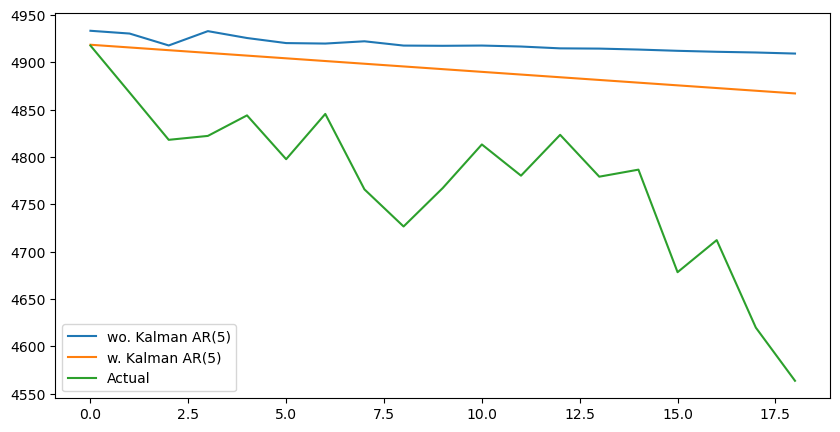

In [11]:
# 可视化预测值与实际值
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(predicted_values_wo_original_scale, label='wo. Kalman AR(5)')
plt.plot(predicted_values_original_scale, label='w. Kalman AR(5)')
plt.plot(test_data_array, label='Actual')
plt.legend()
plt.show()